In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from tensorflow.python import tf2
from keras.datasets import mnist

## Forward-Backward
We will use FB to minimize the function
$$f(x) + g(x) = \frac{1}{2 \lambda}\|Ax-y\|_2^2 + \|x\|_1$$
Let us for the time being omit the $\frac{1}{2\lambda}$ term. For the Forward-Backward method, we require $\nabla f$.
We can find this using directional derivatives. Rewriting, we have
$$f(x) = \|Ax-y\|_2^2 = (Ax-y)^T(Ax-y) = x^TA^TAx - 2x^TA^Ty + y^Ty.$$
The directional derivative of $f$ along $v$ is
$$\nabla_v f(x) = \lim_{h \xrightarrow{} 0} \frac{f(x+hv) - f(x)}{h}$$
$$= \lim_{h \xrightarrow{} 0} \frac{(x+hv)^TA^TA(x+hv) - 2(x+hv)^TA^Ty + y^Ty - x^TA^TAx + 2x^TA^Ty - y^Ty}{h}$$
$$
= \lim_{h \xrightarrow{} 0} 2x^TA^tAv + hv^TA^TAv - 2v^TA^Ty = v^T(2A^TAx - 2A^Ty).
$$
However, from Taylor expansion we also have
$$\nabla_v f(x) = \lim_{h \xrightarrow{} 0} \frac{f(x+hv) - f(x)}{h} \approx \lim_{h \xrightarrow{} 0} \frac{f(x) + hv^T\nabla f(x) - f(x)}{h} = v^T \nabla f(x).$$
Hence from the previous equation we also have
$$\nabla_v f(x) = v^T(2A^TAx - 2A^Ty) = v^T \nabla f(x),$$
and so
$$\nabla f(x) = 2A^TAx - 2A^Ty.$$
Now, the Forward-Backward Algorithm is given to us as
$$x_{n+1} = prox_{\gamma R}\left(x_n - \gamma \nabla f(x_n)\right).$$
In the case that $R(x) = \|x\|_1$, we have
$$prox_{\gamma R} = sign(x) \max{(|x|-\gamma,0)}.$$
Hence, for our current loss function, we have the F-B iteration
$$x_{n+1} = prox_{\gamma R}\left(x_n - \frac{\gamma}{\lambda}\left(A^TAx - A^Ty\right)\right),$$
with $prox$ as above.

In [12]:
def errL2(A,x,y):
    dif = A@x - y
    return dif.T @ dif

In [13]:
def funcreg(A,x,y,lam):
    dif = A@x - y
    fxgx = (1/(2*lam))* (dif.T @ dif) + np.linalg.norm(x,1)
    return fxgx

In [14]:
#Implement thresh/prox function for g(x) = ||1||_1
def prox(x,omg): return np.sign(x) * np.maximum(np.abs(x)-omg,0)

features = 10;
samples = 30;
A = np.random.randn(features,samples)
#Try different matrices
y = np.random.randn(features)
lam = .9 * np.max( A.T @ y )

Final error: 8.916644336544088
Final soln: [ 0.          0.         -0.          0.         -0.          0.01201966
  0.          0.         -0.          0.          0.         -0.00335449
 -0.          0.         -0.          0.         -0.         -0.
  0.         -0.         -0.          0.          0.03639827  0.
 -0.          0.         -0.          0.         -0.         -0.        ]


Text(0.5, 1.0, 'ln(f(x)+g(x))')

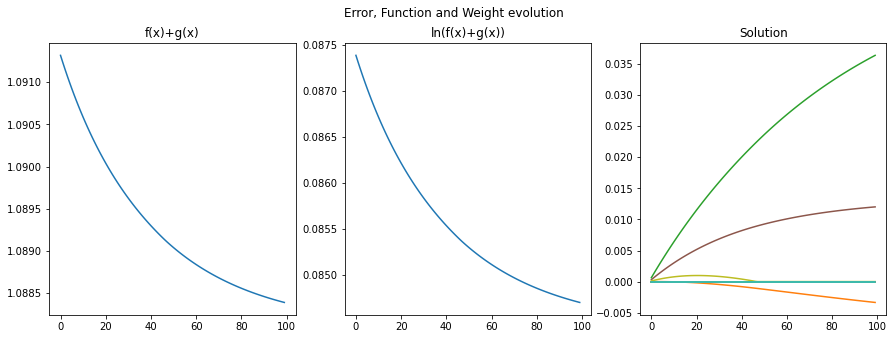

In [15]:
#Implement Forward Backward alg
#initialize x_0 = 0
x = np.zeros(samples)
niter = 100
xtemp = np.zeros((samples,niter))
errvec = np.zeros(niter)
funcvec = np.zeros(niter)
omg = .1/np.linalg.norm(A)
for i in range(niter):
    x = prox(x - (omg/lam)*(np.dot(np.matmul(A.T,A),x) - np.dot(A.T,y)),omg)
    xtemp[:,i] = x
    errvec[i] = errL2(A,x,y)
    funcvec[i] = funcreg(A,x,y,lam)
    
    
print("Final error:", errvec[-1])
print("Final soln:", x)

fig, axs = plt.subplots(1,3, figsize=(15,5))
fig.suptitle('Error, Function and Weight evolution')
axs[0].plot(funcvec.T);
axs[0].set_title('f(x)+g(x)')
axs[2].plot(xtemp.T);
axs[2].set_title('Solution')
axs[1].plot(np.log(funcvec.T));
axs[1].set_title('ln(f(x)+g(x))')

## Gradient Descent
Now, by Theorem 2 in the paper, we have that $(\mathcal{P}_\lambda)$ is equivalent to
$$\min_{v \in \mathbb{R}^k} f(v) \triangleq \min_{u \in \mathbb{R}^n} G(u,v) = \frac{1}{2} h(v \odot v) + \frac{1}{2}\|u\|_2^2 + \frac{1}{\lambda}L \left(X(v \odot_{\mathcal{G}} u),y \right).$$

We will use $h(v \odot v) = \|v\|_2^2$ and $L$ as above. By Corollary 1, $u$ solves
$$(diag(v) X^TX diag(v) + \lambda I)u = v \odot_{\mathcal{G}} (X^Ty),$$
so that
$$u = (diag(v) X^TX diag(v) + \lambda I)^{-1} (v \odot_{\mathcal{G}} (X^Ty)).$$

In order to solve $\min_{v \in \mathbb{R}^k} f(v)$ by Gradient Descent, we find $\nabla f = \frac{\partial f}{\partial v}:$
$$\frac{\partial f}{\partial v} = \partial_v G(u,v) = v + \frac{1}{\lambda} \partial_v L.$$ Now, using chain rule, we have that, denoting $\omega = (v \odot_{\mathcal{G}} u),$
$$\frac{\partial L}{\partial v_i} = \nabla L \cdot \frac{\partial \omega}{\partial v_i},$$
that is
$$\frac{\partial L}{\partial v_i} = \frac{1}{\lambda}\left(X^TX (v \odot_{\mathcal{G}} u) - X^Ty \right) \cdot u',$$
where $u' = (0, \ldots, u_g, \ldots, 0)$. The above can also be reformulated (as per Proposition 3) as
$$\nabla f = v + \frac{1}{\lambda} \left( u \odot (X^\top X (v \odot_{\mathcal{G}} u) - X^\top y) \right)$$
We can now apply Gradient Descent.

In [16]:
def find_u(X,y,v,lam): 
    invm =  np.diag(v) @ (X.T @ (X @ np.diag(v))) + lam * np.eye(np.size(v))
    return np.linalg.inv(invm) @ (np.multiply(v,X.T @ y))

In [17]:
def Gradf(X,y,v,lam):
    u = find_u(X,y,v,lam)
    tempvec = v + (1/lam) * ( u * (X.T @ (X @ (v*u)) - X.T @ y))
    return tempvec

Final error: 8.685164428606608
Final soln: [ 9.52515318e-10  8.63818111e-07 -5.11958371e-10  1.31422842e-09
 -3.18708091e-08  1.72097225e-02  2.13511357e-09  3.02575052e-09
 -8.79339537e-05  7.20187212e-10  2.05667433e-08 -1.01215703e-02
 -8.87242024e-09  3.29253500e-09 -2.94364089e-06  1.34611004e-07
 -9.81514988e-12 -4.54159474e-10  2.71866083e-03 -2.02802450e-05
 -1.32197335e-07  1.63065939e-05  4.84491920e-02  1.21532206e-11
 -3.67326206e-09  1.11273286e-10 -5.09755233e-06  1.14726029e-09
 -9.65915319e-11 -1.93258520e-06]


Text(0.5, 1.0, 'Solution')

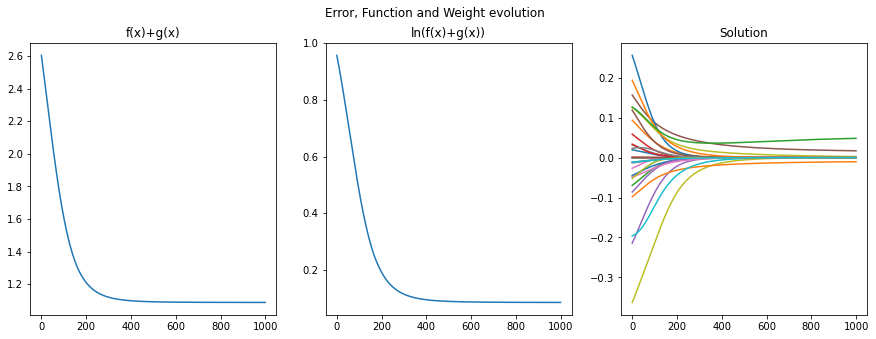

In [18]:
step = 0.01
niter = 1000
errvec2 = np.zeros(niter)
funcvec2 = np.zeros(niter)
v = np.random.randn(samples)
#v = np.zeros(samples)
xtemp2 = np.zeros((samples,niter))
for i in range(niter):
    grad = Gradf(A,y,v,lam)
    v = v - step*grad
    x = v * find_u(A,y,v,lam)
    xtemp2[:,i] = x
    errvec2[i] = errL2(A,x,y)
    funcvec2[i] = funcreg(A,x,y,lam)
    
print("Final error:", errvec2[-1])
print("Final soln:", x)

fig, axs2 = plt.subplots(1,3, figsize=(15,5))
fig.suptitle('Error, Function and Weight evolution')
axs2[1].plot(np.log(funcvec2.T));
axs2[1].set_title('ln(f(x)+g(x))')
axs2[0].plot(funcvec2.T);
axs2[0].set_title('f(x)+g(x)')
axs2[2].plot(xtemp2.T);
axs2[2].set_title('Solution')
    


## Gradient Descent on $u$ and $v$

Now we will compare convergence when using the SGD algorithm, as opposed to Gradient Descent.

Recall from above that if
$$G(u,v) = \frac{1}{2} h(v \odot v) + \frac{1}{2}\|u\|_2^2 + \frac{1}{\lambda}L \left(X(v \odot_{\mathcal{G}} u),y \right) = \frac{1}{2}\|v\|_2^2 + \frac{1}{2}\|u\|_2^2 + \frac{1}{\lambda}L \left(X(v \odot_{\mathcal{G}} u),y \right),$$ 
with L the square-loss function, then we have
$$\partial_v G(u,v) = v + \frac{1}{\lambda} \left( u \odot (X^\top X (v \odot_{\mathcal{G}} u) - X^\top y) \right).$$
Similarly, we have
$$\partial_u G(u,v) = u + \frac{1}{\lambda} \left( v \odot (X^\top X (v \odot_{\mathcal{G}} u) - X^\top y) \right).$$

Now our update step will look like
$$\begin{cases}
u_{k+1} = u_k - \gamma_k\partial_u G(u,v) \\
v_{k+1} = v_k - \gamma_k\partial_v G(u,v)
\end{cases}$$

Regarding which stepsize, $\omega_k$, to use: we can either update $\omega_k$ using Backtracking Line Search or using the Barzilai-Borwein algorithm.

[1]Gabriel Peyré. Mathematical Foundations of Data Sciences, 2021.

In [19]:
def Gux(u,v,X,y,lam):
    dif = X@(u * v) - y
    return (v.T @ v)/2 + (u.T @ u)/2 + (1/lam)*(dif.T @ dif)

In [20]:
def GnabV(u,v,X,y,lam):
    return v + (1/lam)*u*((X.T @ X)@(v*u) - X.T @ y)

In [21]:
def GnabU(u,v,X,y,lam):
    return u + (1/lam)*v*((X.T @ X)@(v*u) - X.T @ y)

In [22]:
def LineSearchU(u,v,X,y,lam):            #Define the Armijo Backtracking Linesearch to find stepsize for u minimization
    tau = 1/2
    c = 1/2
    omg = .1/np.linalg.norm(X)
    grad = GnabU(u,v,X,y,lam)
    t = -c * grad.T @ grad
    while(Gux(u,v,X,y,lam) - Gux((u - omg*grad),v,X,y,lam) < omg*t):
        omg = tau*omg
        
    return omg

In [23]:
def LineSearchV(u,v,X,y,lam):            #Define the Armijo Backtracking Linesearch to find stepsize for v minimization
    tau = 1/2
    c = 1/2
    omg = .1/np.linalg.norm(X)
    grad = GnabV(u,v,X,y,lam)
    t = -c * grad.T @ grad
    while(Gux(u,v,X,y,lam) - Gux(u,(v - omg*grad),X,y,lam) < omg*t):
        omg = tau*omg
        
    return omg

Final error: 7.356835794082044
Final soln: [ 0.00829583  0.03636545 -0.00627434  0.00169131 -0.00031419  0.02211187
  0.00153459 -0.00019646 -0.0637773   0.00048179  0.00382608 -0.02854969
 -0.00067604  0.00235033 -0.00296629  0.00364998 -0.00086666 -0.00013613
  0.04536984 -0.00034068 -0.03925844  0.02943115  0.01049811  0.00010481
 -0.0002121   0.0002397  -0.00299337  0.000387   -0.00422102 -0.00918544]


Text(0.5, 1.0, 'Stepsize')

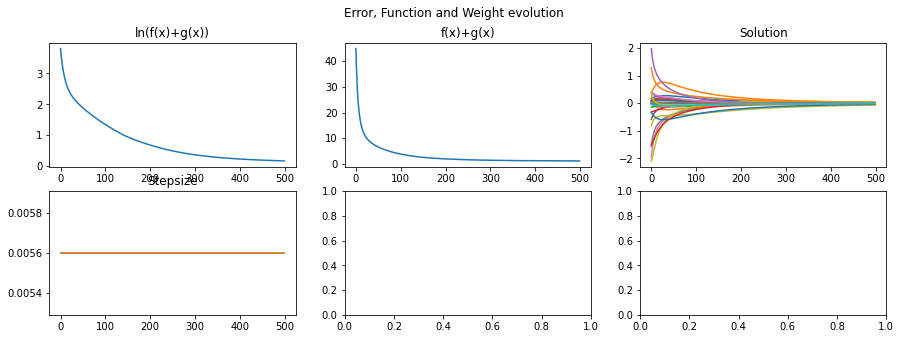

In [24]:
#Do gradient descent with step chosen using Armijo Backtracking Line Search
step = 0.001
niter = 500
errvec3 = np.zeros(niter)
u = np.random.randn(samples)
v = np.random.randn(samples)
xtemp3 = np.zeros((samples,niter))
funcvec3 = np.zeros(niter)
steparr = np.zeros((2,niter))
for i in range(niter):
    #rndindx = np.random.randint(0, samples, 1)[0]
    #ch_sample = A[:,rndindx].reshape(-1,1)
    gradu = GnabU(u,v,A,y,lam)
    gradv = GnabV(u,v,A,y,lam)
    stepu = LineSearchU(u,v,A,y,lam)
    stepv = LineSearchV(u,v,A,y,lam)
    steparr[0,i] = stepu
    steparr[1,i] = stepv
    u = u - stepu*gradu
    v = v - stepv*gradv
    x = u * v
    xtemp3[:,i] = x
    errvec3[i] = errL2(A,x,y)
    funcvec3[i] = funcreg(A,x,y,lam)
    #print(stepu)
    
print("Final error:", errvec3[-1])
print("Final soln:", x)

fig, axs3 = plt.subplots(2,3, figsize=(15,5))
fig.suptitle('Error, Function and Weight evolution')
axs3[0,0].plot(np.log(funcvec3.T));
axs3[0,0].set_title('ln(f(x)+g(x))')
axs3[0,1].plot(funcvec3.T);
axs3[0,1].set_title('f(x)+g(x)')
axs3[0,2].plot(xtemp3.T);
axs3[0,2].set_title('Solution')
axs3[1,0].plot(steparr.T);
axs3[1,0].set_title('Stepsize')

In [25]:
def BBstep(xt,xtm1,gradt,gradtm1):    #Function for Barzilai-Borwein stepsize
    st = xt - xtm1
    yt = gradt - gradtm1
    return (st.T @ st) / (st.T @ yt)

In [26]:
a = np.arange(1,26)
a = a.reshape(5,5)
print(a)
k = np.array([[1,0,0],[0,1,0],[0,0,1]])
ndimage.convolve(a, k, mode='constant', cval=0.0)

[[ 1  2  3  4  5]
 [ 6  7  8  9 10]
 [11 12 13 14 15]
 [16 17 18 19 20]
 [21 22 23 24 25]]


array([[ 8, 10, 12, 14,  5],
       [18, 21, 24, 27, 14],
       [28, 36, 39, 42, 24],
       [38, 51, 54, 57, 34],
       [21, 38, 40, 42, 44]])

Final error: 8.719656595448061
Final soln: [ 1.67216360e-162  9.44188095e-066 -8.16377382e-100  6.65162738e-171
 -3.30932228e-138  1.36196996e-002  3.33745594e-060  2.78433788e-126
 -2.89407131e-041  0.00000000e+000  6.18016547e-136 -7.61342274e-003
 -4.09021600e-123  3.71443766e-129 -2.84046484e-036  2.55859008e-085
 -0.00000000e+000 -4.53229414e-195  6.73028694e-011 -3.25769972e-049
 -8.14394152e-079  2.39693904e-048  5.31345922e-002  1.19736809e-307
 -1.55541095e-154  1.74543115e-143 -4.06864973e-051  5.03109114e-224
 -0.00000000e+000 -3.26360212e-044]


Text(0.5, 1.0, 'Stepsize')

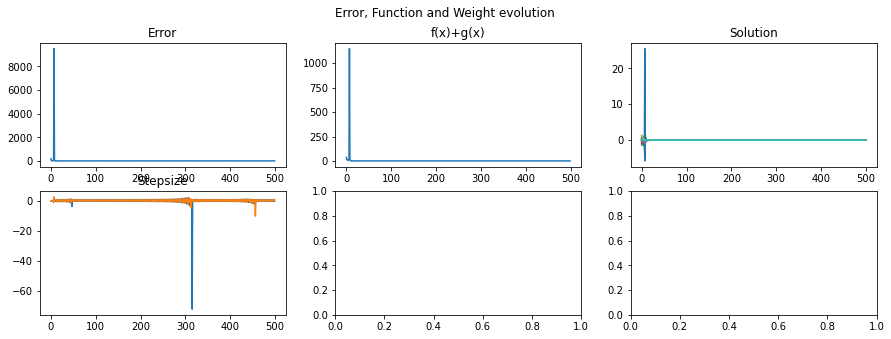

In [27]:
#Do gradient descent with step chosen using Barzilai-Borwein
step = 0.001
niter = 500
errvec3 = np.zeros(niter)
u = np.random.randn(samples)
v = np.random.randn(samples)
xtemp3 = np.zeros((samples,niter))
funcvec3 = np.zeros(niter)
steparr = np.zeros((2,niter))
uold = u
vold = v
for i in range(niter):
    #rndindx = np.random.randint(0, samples, 1)[0]
    #ch_sample = A[:,rndindx].reshape(-1,1)
    gradu = GnabU(u,v,A,y,lam)
    gradv = GnabV(u,v,A,y,lam)
    #stepu = LineSearchU(u,v,ch_sample,y,lam)
    #stepv = LineSearchV(u,v,ch_sample,y,lam)
    stepu = .1/np.linalg.norm(A)
    stepv = .1/np.linalg.norm(A)
    if(i > 0):
        stepu = BBstep(u,uold,GnabU(u,v,A,y,lam),GnabU(uold,vold,A,y,lam))
        stepv = BBstep(v,vold,GnabV(u,v,A,y,lam),GnabV(uold,vold,A,y,lam))
    
    steparr[0,i] = stepu
    steparr[1,i] = stepv
    uold = u
    vold = v
    u = u - stepu*gradu
    v = v - stepv*gradv
    x = u * v
    xtemp3[:,i] = x
    errvec3[i] = errL2(A,x,y)
    funcvec3[i] = funcreg(A,x,y,lam)
    #print(stepu)
    
print("Final error:", errvec3[-1])
print("Final soln:", x)

fig, axs3 = plt.subplots(2,3, figsize=(15,5))
fig.suptitle('Error, Function and Weight evolution')
axs3[0,0].plot(errvec3.T);
axs3[0,0].set_title('Error')
axs3[0,1].plot(funcvec3.T);
axs3[0,1].set_title('f(x)+g(x)')
axs3[0,2].plot(xtemp3.T);
axs3[0,2].set_title('Solution')
axs3[1,0].plot(steparr.T);
axs3[1,0].set_title('Stepsize')

In [28]:
#Now try with real data - load MNIST digits
(train_X, train_y), (test_X, test_y) = mnist.load_data()

Now, note that
$$\frac{1}{2}\|Ax-y\|_2^2 = \frac{1}{2}\sum^m_{i=1} \left(\langle A_i, x \rangle - y_i \right)^2 = \frac{1}{2}\sum^m_{i=1} Q_i = \frac{1}{2}\sum^m_{i=1} L_i^2 $$

Thus, a partial derivative w.r.t $x_i$ is just
$$\nabla Q_i(x) = L_i \cdot A_i^T,$$

where $A_i$ is the $i$-th row of the matrix $A$, corresponding to the $i$-th sample.

Furrthermore, if we have that $x = u \odot v,$ then by chain rule we have
$$\nabla_u Q_i(x) = L_i \cdot A_i^T \odot v.$$
$$\nabla_v Q_i(x) = L_i \cdot A_i^T \odot u.$$

In [73]:
def SGnabV(u,v,X,y,lam,indx):             #Stochastic Gradient for V
    Xi = X[indx,:]
    Li = Xi @ (u*v) - y[indx]
    return u + (1/lam)*Li*(Xi.T @ u)

In [74]:
def SGnabU(u,v,X,y,lam,indx):             #Stochastic Gradient for U
    Xi = X[indx,:]
    Li = Xi @ (u*v) - y[indx]
    return v + (1/lam)*Li*(Xi.T @ v)

Final error: nan
Final soln: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]


<ipython-input-25-97cbe1c77617>:4: RuntimeWarning: invalid value encountered in double_scalars
  return (st.T @ st) / (st.T @ yt)


Text(0.5, 1.0, 'Stepsize')

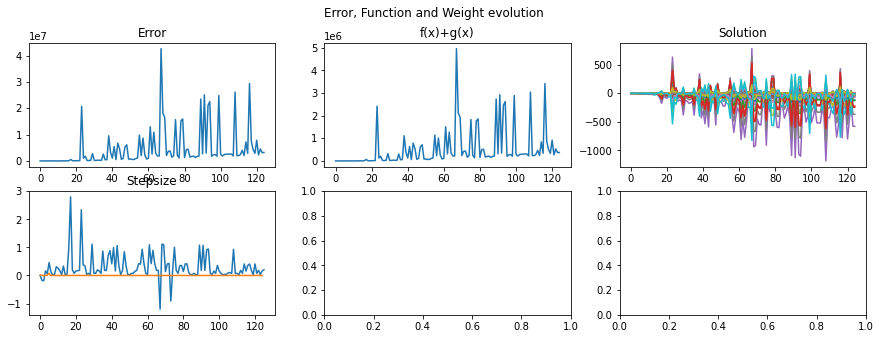

In [71]:
#Do stochastic gradient descent with step chosen using Barzilai-Borwein
step = 0.001
niter = 500
errvec3 = np.zeros(niter)
u = np.random.randn(samples)
v = np.random.randn(samples)
xtemp3 = np.zeros((samples,niter))
funcvec3 = np.zeros(niter)
steparr = np.zeros((2,niter))
uold = u
vold = v
for i in range(niter):
    rndindx = np.random.randint(0, features-1)
    gradu = SGnabU(u,v,A,y,lam,rndindx)
    gradv = SGnabV(u,v,A,y,lam,rndindx)
    #stepu = LineSearchU(u,v,ch_sample,y,lam)
    #stepv = LineSearchV(u,v,ch_sample,y,lam)
    stepu = .1/np.linalg.norm(A)
    stepv = .1/np.linalg.norm(A)
    if(i > 0):
        stepu = BBstep(u,uold,gradu,SGnabU(uold,vold,A,y,lam,rndindx))
        stepv = BBstep(v,vold,gradu,SGnabV(uold,vold,A,y,lam,rndindx))
    
    steparr[0,i] = stepu
    steparr[1,i] = stepv
    uold = u
    vold = v
    u = u - stepu*gradu
    v = v - stepv*gradv
    x = u * v
    xtemp3[:,i] = x
    errvec3[i] = errL2(A,x,y)
    funcvec3[i] = funcreg(A,x,y,lam)
    #print(stepu)
    
print("Final error:", errvec3[-1])
print("Final soln:", x)

fig, axs3 = plt.subplots(2,3, figsize=(15,5))
fig.suptitle('Error, Function and Weight evolution')
axs3[0,0].plot(errvec3.T);
axs3[0,0].set_title('Error')
axs3[0,1].plot(funcvec3.T);
axs3[0,1].set_title('f(x)+g(x)')
axs3[0,2].plot(xtemp3.T);
axs3[0,2].set_title('Solution')
axs3[1,0].plot(steparr.T);
axs3[1,0].set_title('Stepsize')

Final error: 2.1309600634021524e+33
Final soln: [2.29323552e+15 2.29323576e+15 2.29323712e+15 2.29323719e+15
 2.29323709e+15 2.29323829e+15 2.29323574e+15 2.29323675e+15
 2.29323416e+15 2.29323387e+15 2.29323689e+15 2.29323803e+15
 2.29323369e+15 2.29323628e+15 2.29323794e+15 2.29323452e+15
 2.29323769e+15 2.29323554e+15 2.29323476e+15 2.29323428e+15
 2.29323500e+15 2.29323622e+15 2.29323642e+15 2.29323705e+15
 2.29323680e+15 2.29323712e+15 2.29323558e+15 2.29323520e+15
 2.29323730e+15 2.29323702e+15]


Text(0.5, 1.0, 'Stepsize')

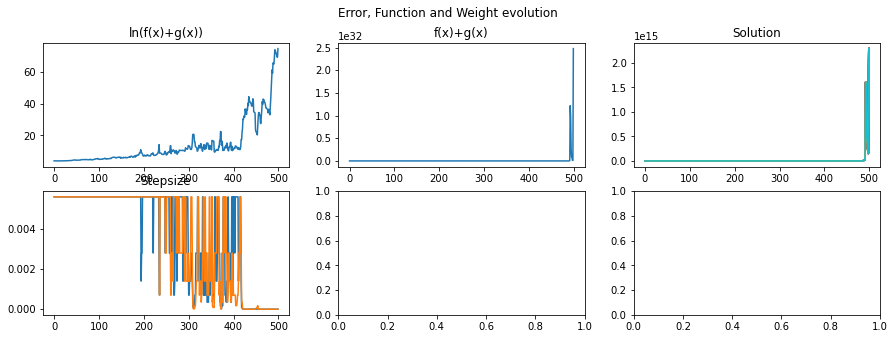

In [75]:
#Do stochastic gradient descent with step chosen using Armijo Backtracking Line Search
step = 0.001
niter = 500
errvec3 = np.zeros(niter)
u = np.random.randn(samples)
v = np.random.randn(samples)
xtemp3 = np.zeros((samples,niter))
funcvec3 = np.zeros(niter)
steparr = np.zeros((2,niter))
for i in range(niter):
    rndindx = np.random.randint(0, features-1)
    gradu = SGnabU(u,v,A,y,lam,rndindx)
    gradv = SGnabV(u,v,A,y,lam,rndindx)
    stepu = LineSearchU(u,v,A,y,lam)
    stepv = LineSearchV(u,v,A,y,lam)
    steparr[0,i] = stepu
    steparr[1,i] = stepv
    u = u - stepu*gradu
    v = v - stepv*gradv
    x = u * v
    xtemp3[:,i] = x
    errvec3[i] = errL2(A,x,y)
    funcvec3[i] = funcreg(A,x,y,lam)
    #print(stepu)
    
print("Final error:", errvec3[-1])
print("Final soln:", x)

fig, axs3 = plt.subplots(2,3, figsize=(15,5))
fig.suptitle('Error, Function and Weight evolution')
axs3[0,0].plot(np.log(funcvec3.T));
axs3[0,0].set_title('ln(f(x)+g(x))')
axs3[0,1].plot(funcvec3.T);
axs3[0,1].set_title('f(x)+g(x)')
axs3[0,2].plot(xtemp3.T);
axs3[0,2].set_title('Solution')
axs3[1,0].plot(steparr.T);
axs3[1,0].set_title('Stepsize')

# Stochastic Forward-Backward

We modify the F-B algorithm to work with SGD, rather than batch descent.